# **Divide2Conquer (D2C)**
This notebook contains the code and implementation details (for text classification using AG News dataset in this case) on our proposed method, **Divide2Conquer (D2C)** to address the issue of **Overfitting** in Deep Learning models. We propose partitioning the training data into multiple subsets and training separate identical models on them. To avoid overfitting on any specific subset, the trained parameters from these models are aggregated and scaled periodically throughout the training phase, enabling the model to learn from the entire dataset while mitigating the impact of individual outliers or noise.

## **Importing Necessary Packages & Mounting Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import sys
import pandas as pd
import json
import csv
import random
import numpy as np
import os
from imutils import paths
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import sklearn.metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, cohen_kappa_score, f1_score, matthews_corrcoef, log_loss, accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import seaborn as sns

sys.path.append('/content/drive/MyDrive/IAR Research Grant/Codes/Refined Codes')
from d2c_utils import *

## **Creating Necessary Functions**

In [ ]:
def create_subsets(seq_list, label_list, num_subsets=3, initial='subset'):
    ''' return: a dictionary with keys subset names and value as
                data shards - tuple of sequence and label lists.
        args:
            seq_list: a list of numpy arrays of inputs
            label_list:a list of binarized labels for each sequence
            num_subsets: number of training subsets
            initials: the subset name prefix, e.g, subset_1

    '''

    #create a list of subset no.
    subset_no = ['{}_{}'.format(initial, i+1) for i in range(num_subsets)]

    #randomize the data
    data = list(zip(seq_list, label_list))
    random.shuffle(data)

    #shard data and place at each subset
    size = len(data)//num_subsets
    shards = [data[i:i + size] for i in range(0, size*num_subsets, size)]

    #number of subsets must equal number of shards
    assert(len(shards) == len(subset_no))

    return {subset_no[i] : shards[i] for i in range(len(subset_no))}

In [ ]:
def batch_data(data_shard, bs=32):
    '''Takes in a subsets' data shard and creates a tfds object off it
    args:
        shard: a data, label constituting a subsets' data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)

### **Data Preprocessing**

In [ ]:
embedding_dim = 100
max_length = 80
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 120000 # Dataset Size
val_portion = .1

corpus = []

In [ ]:
num_sentences = 0

with open("/content/drive/MyDrive/IAR Research Grant/Data/Text Datasets/AG_train.csv", encoding="utf8") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        list_item=[]

        #Creating list items where the first item is the text, found in row[0], and the second is the label.
        sentence = row[0]
        list_item.append(sentence)
        list_item.append(int(row[1]))

        num_sentences = num_sentences + 1
        corpus.append(list_item)

In [ ]:
sentences=[]
labels=[]
random.shuffle(corpus)
for x in range(training_size):
    sentences.append(corpus[x][0])
    labels.append(corpus[x][1])


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

word_index = tokenizer.word_index
vocab_size=len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, padding='post', maxlen = max_length, truncating=trunc_type)

split = int(val_portion * training_size)

val_sequences = np.array(padded[0:split])
training_sequences = np.array(padded[split:training_size])
val_labels = np.array(labels[0:split])
training_labels = np.array(labels[split:training_size])

In [ ]:
print(vocab_size)
#print(word_index)
#print(sequences[0])
#print(padded[0])
#print(training_sequences[0])
#print(training_labels[0])

70344

In [ ]:
# Note that this is the 100 dimension version of GloVe from Stanford

# glove.6B.100d.txt
#!gdown --id 1W5vZy2etitAblLdFn8_DxnsQKzfFJ98g

embeddings_index = {};
with open('/content/drive/MyDrive/IAR Research Grant/Codes/Text Classification Codes/glove.6B.100d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [ ]:
#binarize the labels
lb = LabelBinarizer()
y_train = lb.fit_transform(training_labels)
y_val = lb.fit_transform(val_labels)

# **Setting Hyperparameter Values**
The new global hyperparameters that need tuning, in this case, are the **Number of Subsets of the Training Set** and the **Number of Epochs before each round of Global Averaging**. To refer to them concisely, we will use the variables **N** and **E** respectively.

In [ ]:
# Setting the Number of Subsets of the Training Set, N
N = 5

# Setting the Number of Epochs before each round of Global Averaging, E
E = 2

# **Creating Subsets**

In [ ]:
#create subsets
subsets = create_subsets(training_sequences, y_train, num_subsets=N, initial='subset')

In [ ]:
#process and batch the training data for each subset
subsets_batched = dict()
for (subset_no, data) in subsets.items():
    subsets_batched[subset_no] = batch_data(data)

#process and batch the train set
train_batched = tf.data.Dataset.from_tensor_slices((training_sequences, y_train)).batch(len(y_train))
#process and batch the validation set
val_batched = tf.data.Dataset.from_tensor_slices((val_sequences, y_val)).batch(len(y_val))

# **Constructing the Deep Learning Model**
The Network Architecture is shown in the picture below..
<div style="text-align: center;">
    <img src="LSTM_Horizontal.png" alt="The Bi-LSTM based Model" width="1200"/>
</div>

In [ ]:
class RNNModel:
    @staticmethod
    def build(classes):
        model = Sequential()
        model.add(Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False))
        #model.add(Dropout(0.1))
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(64, return_sequences=True)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(32)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        model.add(Dense(64))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.4))
        model.add(Dense(4))
        #model.add(Activation("softmax"))
        return model

In [ ]:
lr = 0.001
comms_round = 25
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']
optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001, epsilon=0.001, amsgrad=True)

Accu = []
Loss = []
Tr_Accu = []
Tr_Loss =[]

# **Training The Subset Models And Central Averaging**
The whole process is summarized in the picture below..
<div style="text-align: center;">
    <img src="D2C_Method.png" alt="D2C Method at a Glance" width="600"/>
</div>

In [ ]:
#initialize Central model
rnn_central = RNNModel()
central_model = rnn_central.build(4)
best_model = rnn_central.build(4)

#commence global training loop
for comm_round in range(comms_round):

    # get the Central model's weights - will serve as the initial weights for all Subset models
    central_weights = central_model.get_weights()

    #initial list to collect subset model weights after scalling
    scaled_subset_weight_list = list()

    #randomize subset data - using keys
    subsets= list(subsets_batched.keys())
    random.shuffle(subsets)

    #loop through each subset and create new subset model
    for subset in subsets:
        rnn_subset = RNNModel()
        subset_model = rnn_subset.build(4)
        subset_model.compile(loss=loss,
                      optimizer=optimizer,
                      metrics=metrics)

        #set subset model weight to the weight of the Central model
        subset_model.set_weights(central_weights)

        #fit subset model with subset's data
        subset_model.fit(subsets_batched[subset], epochs=E, verbose=0)

        #scale the model weights and add to list
        scaling_factor = weight_scalling_factor(subsets_batched, subset)
        scaled_weights = scale_model_weights(subset_model.get_weights(), scaling_factor)
        scaled_subset_weight_list.append(scaled_weights)

        #clear session to free memory after each global epoch
        K.clear_session()

    #to get the average over all the subset models, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_subset_weight_list)

    #update Central model
    central_model.set_weights(average_weights)

    #test Central model and print out metrics after each global epoch
    for(training_sequences, y_train) in train_batched:
        central_train_acc, central_train_loss = test_train_model(training_sequences, y_train, central_model, comm_round)
        Tr_Accu.append(central_train_acc)
        Tr_Loss.append(central_train_loss)
    for(val_sequences, y_val) in val_batched:
        central_acc, central_loss = test_model(val_sequences, y_val, central_model, comm_round)
        Accu.append(central_acc)
        Loss.append(central_loss)

    if central_acc == max(Accu):
        best_model.set_weights(average_weights)

3375/3375 [==============================] - 32s 9ms/step
comm_round: 0 | global_training_acc: 62.957% | global_training_loss: 0.9628766775131226
375/375 [==============================] - 3s 9ms/step
comm_round: 0 | global_acc: 62.400% | global_loss: 0.9699033498764038
3375/3375 [==============================] - 31s 9ms/step
comm_round: 1 | global_training_acc: 89.785% | global_training_loss: 0.32263562083244324
375/375 [==============================] - 3s 9ms/step
comm_round: 1 | global_acc: 89.458% | global_loss: 0.3296586871147156
3375/3375 [==============================] - 31s 9ms/step
comm_round: 2 | global_training_acc: 90.509% | global_training_loss: 0.3005167841911316
375/375 [==============================] - 3s 9ms/step
comm_round: 2 | global_acc: 90.150% | global_loss: 0.31083035469055176
3375/3375 [==============================] - 31s 9ms/step
comm_round: 3 | global_training_acc: 91.107% | global_training_loss: 0.2721060812473297
375/375 [==============================

# **Model Validation**

375/375 [==============================] - 6s 9ms/step


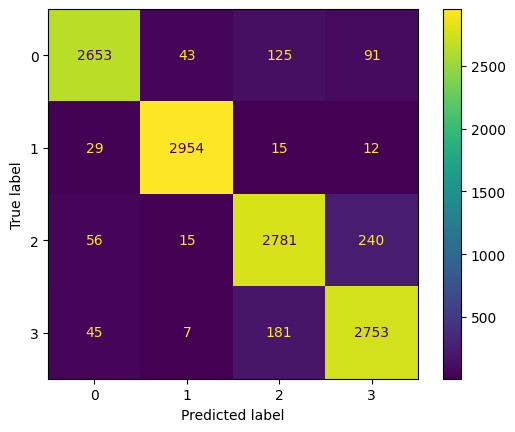

In [ ]:
pred = tf.nn.softmax(best_model.predict(val_sequences))
y_pred=np.argmax(pred,axis=1)
rounded_labels=np.argmax(y_val, axis=1)
Confusion_Matrix = sklearn.metrics.confusion_matrix(rounded_labels, y_pred)
Disp = ConfusionMatrixDisplay(Confusion_Matrix)
Disp.plot()
plt.show()

In [ ]:
y_pred_proba = tf.nn.softmax(best_model.predict(val_sequences))

ROC_AUC = roc_auc_score(rounded_labels, y_pred_proba, multi_class='ovr')
Cohen_Kappa = cohen_kappa_score(rounded_labels, y_pred)
F1 = f1_score(rounded_labels, y_pred, average='macro')
Matthews = matthews_corrcoef(rounded_labels, y_pred)
Log = log_loss(rounded_labels, y_pred_proba)
Accuracy = accuracy_score(rounded_labels, y_pred)

print('ROC_AUC Score:', ROC_AUC)
print('Cohen_Kappa Score:', Cohen_Kappa)
print('F1 Score:', F1)
print('Matthews Correlation Coefficient:', Matthews)
print('Log Loss:', Log)
print('Accuracy:', Accuracy)

375/375 [==============================] - 3s 9ms/step
ROC_AUC Score: 0.9891284261381338
Cohen_Kappa Score: 0.9045314002318772
F1 Score: 0.9287212224872847
Matthews Correlation Coefficient: 0.9046525869992296
Log Loss: 0.2493045174886051
Accuracy: 0.9284166666666667


(0.0, 0.45)

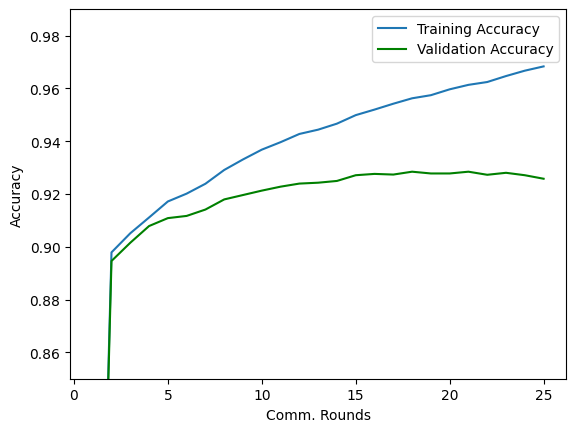

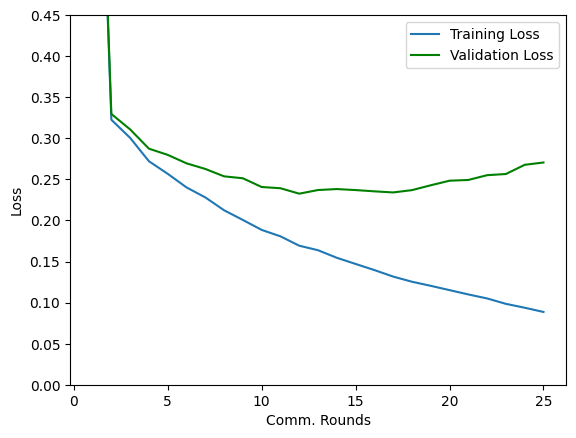

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = Tr_Accu
val_acc  = Accu
loss     = Tr_Loss
val_loss = Loss

epochs   = range(1,len(acc)+1) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.figure()
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc, color = 'g')
#plt.title ('Training and Validation Accuracy with FedNet Implementation on CIFAR-10')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.xlabel('Comm. Rounds')
plt.ylabel('Accuracy')
plt.ylim(0.85,0.99)

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure()
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss, color = 'g' )
#plt.title ('Training and Validation Loss with FedNet Implementation on CIFAR-10')
plt.legend(['Training Loss','Validation Loss'])
plt.xlabel('Comm. Rounds')
plt.ylabel('Loss')
plt.ylim(0,0.45)

## **Test Set Evaluation**

238/238 [==============================] - 4s 9ms/step


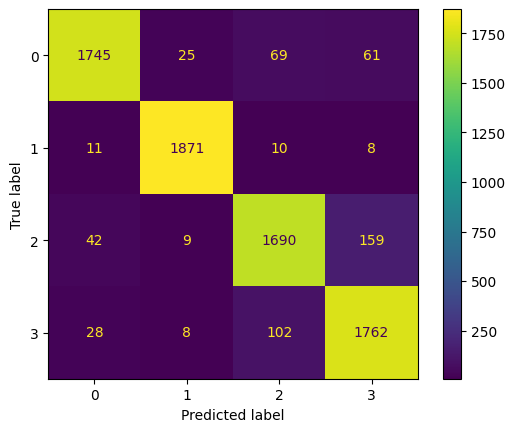

238/238 [==============================] - 2s 10ms/step
ROC_AUC Score: 0.9889718144044322
Cohen_Kappa Score: 0.9066666666666666
F1 Score: 0.9300668404170901
Matthews Correlation Coefficient: 0.906819344188888
Log Loss: 0.24670618991839588
Accuracy: 0.93


In [ ]:
num_sentences = 0
test_corpus = []
test_size = 7600
with open("/content/drive/MyDrive/IAR Research Grant/Data/Text Datasets/AG_test.csv", encoding="utf8") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        list_item=[]

        #Creating list items where the first item is the text, found in row[0], and the second is the label.
        sentence = row[0]
        list_item.append(sentence)
        list_item.append(row[1])

        num_sentences = num_sentences + 1
        test_corpus.append(list_item)


test_sentences=[]
test_labels=[]
random.shuffle(test_corpus)
for x in range(test_size):
    test_sentences.append(test_corpus[x][0])
    test_labels.append(test_corpus[x][1])

test_word_index = tokenizer.word_index
vocab_size=len(test_word_index)

Test_sequences = tokenizer.texts_to_sequences(test_sentences)
Test_padded = pad_sequences(Test_sequences, padding='post', maxlen = max_length, truncating=trunc_type)

Test_sequences = np.array(Test_padded)
Test_labels = np.array(test_labels)

y_test = lb.fit_transform(Test_labels)

pred = tf.nn.softmax(best_model.predict(Test_sequences))
y_pred=np.argmax(pred,axis=1)
rounded_labels=np.argmax(y_test, axis=1)
Confusion_Matrix = sklearn.metrics.confusion_matrix(rounded_labels, y_pred)
Disp = ConfusionMatrixDisplay(Confusion_Matrix)
Disp.plot()
plt.show()

y_pred_proba = tf.nn.softmax(best_model.predict(Test_sequences))

ROC_AUC = roc_auc_score(rounded_labels, y_pred_proba, multi_class='ovr')
Cohen_Kappa = cohen_kappa_score(rounded_labels, y_pred)
F1 = f1_score(rounded_labels, y_pred, average='macro')
Matthews = matthews_corrcoef(rounded_labels, y_pred)
Log = log_loss(rounded_labels, y_pred_proba)
Accuracy = accuracy_score(rounded_labels, y_pred)

print('ROC_AUC Score:', ROC_AUC)
print('Cohen_Kappa Score:', Cohen_Kappa)
print('F1 Score:', F1)
print('Matthews Correlation Coefficient:', Matthews)
print('Log Loss:', Log)
print('Accuracy:', Accuracy)


## **Saving the Model**

In [ ]:
best_model.save('AG_News_Central_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
best_model.save('/content/drive/MyDrive/IAR Research Grant/Codes/Refined Codes/AG_News_Central_model.keras')